# **Project 3: Distributing COVID Vaccines**


##  **Introduction**
The goal of this project is to estimate the cost of shipping of Covid-19 vaccines from Yale New Haven Hospital, Hartford Hospital, and Lawrence and Memorial Hospital to 10 selected towns in the Tolland county. We will build 3 models to come up with the most cost-efficient distribution approach:
- Minimal Cost Flow Model
- Monte Carlo Simulation with the constraint that at least 30% supply comes from each hospital 
- Monte Carlo Simulation with the constraint that at least 10% supply comes from each hospital
![picture](https://as01.epimg.net/en/imagenes/2020/11/25/latest_news/1606326164_750579_1606326333_noticia_normal.jpg)

## **1. Import Libraries**

In [ ]:
# We are mounting the Google Drive:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd # We are importing Pandas module useful for data analysis
import numpy as np # We are importing Numpy module for numeric functions

# We are setting up the environment by importing the necessary Python modules for map:
# Important library for many geopython libraries:
!apt install gdal-bin python-gdal python3-gdal 
# Installing rtree - Geopandas requirment:
!apt install python3-rtree 
# Installing Geopandas:
!pip install git+git://github.com/geopandas/geopandas.git
# Installing descartes - Geopandas requirment:
!pip install descartes 
# Installing Folium for Geographic data visualization:
!pip install folium
# Installing plotlyExpress:
!pip install plotly_express

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe

## **2. Read Centroids Data**

The original csv file contains the data for all counties in Connecticut.

In [ ]:
# We are reading the csv file:
df = pd.read_csv('/content/drive/MyDrive/OPIM 5641 - Group Project 2 and 3/Project 3/Data/townCentroids.csv')

df.head()

X          Y  ...              DEP_DIST COAST_AREA
0 -73.425651  41.986019  ...  DEP Western District        NaN
1 -73.293569  42.022264  ...  DEP Western District        NaN
2 -73.196224  41.980145  ...  DEP Western District        NaN
3 -73.080811  42.001546  ...  DEP Western District        NaN
4 -72.948897  42.004293  ...  DEP Western District        NaN

[5 rows x 11 columns]

We were assigned the Tolland county, which has 13 towns. We are filtering out our county from raw data and adding the confirmed cases column.

In [ ]:
# We are filtering out the towns in Tolland county:
towns = df.loc[df['COUNTY'] == 'Tolland', ['TOWN', 'X', 'Y']]

# We are setting the index to town short names - will be useful when we create model nodes:
towns['Index'] = towns['TOWN'].str.upper().str[0] + towns['TOWN'].str.upper().str[-1]
towns.set_index('Index', inplace= True)

# We are adding the cases - the number of cases as of the 28th of October:
towns['Cases'] = [323, 130, 4, 30, 133, 82, 362, 90, 327, 39, 16, 32, 55]

# We are printing the town dataframe:
towns

TOWN          X          Y  Cases
Index                                         
SS         Somers -72.453051  41.994879    323
SD       Stafford -72.312328  41.987521    130
UN          Union -72.160264  41.993025      4
WN     Willington -72.259370  41.889536     30
EN      Ellington -72.448494  41.915139    133
TD        Tolland -72.364935  41.878579     82
VN         Vernon -72.460747  41.836415    362
CY       Coventry -72.339406  41.782915     90
MD      Mansfield -72.228732  41.789205    327
BN         Bolton -72.439088  41.766402     39
AR        Andover -72.376108  41.733134     16
CA       Columbia -72.306977  41.693923     32
HN         Hebron -72.390321  41.659368     55

## **3. Select 10 Towns in the Tolland County**
We looked at the number of Covid-19 cases in each Tolland county town and decided to remove towns with the lowest incidence of cases since their demand for vaccines will be low - Union, Andover, and Willington.
The towns that we will include in subsequent analyses are:
- Somers
- Stafford
- Ellington
- Tolland
- Vernon
- Coventry
- Mansfield
- Bolton
- Columbia
- Hebron

In [ ]:
# We are filtering out the towns that we did not select (Union, Willington, Andover): 
selectedtowns = towns.loc[~towns['TOWN'].isin(['Union', 'Willington', 'Andover'])]
selectedtowns

TOWN          X          Y  Cases
Index                                        
SS        Somers -72.453051  41.994879    323
SD      Stafford -72.312328  41.987521    130
EN     Ellington -72.448494  41.915139    133
TD       Tolland -72.364935  41.878579     82
VN        Vernon -72.460747  41.836415    362
CY      Coventry -72.339406  41.782915     90
MD     Mansfield -72.228732  41.789205    327
BN        Bolton -72.439088  41.766402     39
CA      Columbia -72.306977  41.693923     32
HN        Hebron -72.390321  41.659368     55

We are creating a dataframe for hospital coordinates and vaccine availability.

In [ ]:
# We are creating a dictionary with the hospital data:
dicthospital = {'YNHH': ['Yale New Haven Hospital', -72.9356, 41.3044, 10000000], 
                'HH': ['Hartford Hospital', -72.6778707 , 41.7545445,10000000], 
                'LMH': ['Lawrence and Memorial Hospital',-72.1046 , 41.3363, 10000000]}

# We are converting it to dataframe - to be used for model creation:
dfhospital = pd.DataFrame.from_dict(dicthospital, orient = 'index', columns=['Name', 'X', 'Y', 'Vaccines'])

dfhospital

Name          X          Y  Vaccines
YNHH         Yale New Haven Hospital -72.935600  41.304400  10000000
HH                 Hartford Hospital -72.677871  41.754545  10000000
LMH   Lawrence and Memorial Hospital -72.104600  41.336300  10000000

## **4. Map the Hospitals and Selected Tolland County Towns**

Now, we are mapping out the geographical locations of each town and three hospitals. Looks like all of our towns are close to Hartford Hospital.

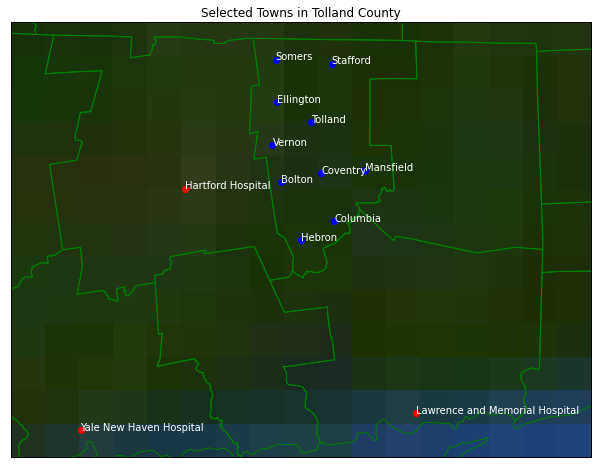

In [ ]:
# We are setting the figure size:
fig = plt.figure(figsize=(12,8))

# We are creating Basemap object, with center as lat_0 and lon_0 - helps to position the map:
m = Basemap(projection='lcc', resolution='h', 
            lat_0=41.659368, lon_0=-72.390321,
            width=120000, height=90000, suppress_ticks=True)

# These are required to plot the hospitals:
Hospitals = dfhospital['Name'].values
latitudes_y = dfhospital['Y'].values
longitude_x = dfhospital['X'].values
x,y = m(longitude_x, latitudes_y)

# We are plotting the hospitals' coordinates:
m.plot(x,y,'ro')

# We are labelling the coordinates:
plt.text(x[0],y[0], Hospitals[0] , fontsize=10,  color='white')
plt.text(x[1],y[1], Hospitals[1], fontsize=10,  color='white')
plt.text(x[2],y[2], Hospitals[2], fontsize=10,  color='white')

# Towns in Tolland county:
lat_x_town = selectedtowns['X'].values
lon_y_town = selectedtowns['Y'].values
xTown,yTown =  m(lat_x_town, lon_y_town)

# We are plotting the points:
m.plot(xTown,yTown,'bo')

# We are labelling the points:
plt.text(xTown[0],yTown[0], 'Somers', fontsize=10,  color='white')
plt.text(xTown[1],yTown[1], 'Stafford', fontsize=10,  color='white')
plt.text(xTown[2],yTown[2], 'Ellington', fontsize=10,  color='white')
plt.text(xTown[3],yTown[3], 'Tolland', fontsize=10,  color='white')
plt.text(xTown[4],yTown[4], 'Vernon', fontsize=10,  color='white')
plt.text(xTown[5],yTown[5], 'Coventry', fontsize=10,  color='white')
plt.text(xTown[6],yTown[6], 'Mansfield', fontsize=10,  color='white')
plt.text(xTown[7],yTown[7], 'Bolton', fontsize=10,  color='white')
plt.text(xTown[8],yTown[8], 'Columbia', fontsize=10,  color='white')
plt.text(xTown[9],yTown[9], 'Hebron', fontsize=10,  color='white')

# For county border:
m.drawcounties(linewidth=1.0, linestyle='solid',color='green')

# We are drawing the parallels and meridians:
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.bluemarble()
m.drawmapboundary()

plt.title("Selected Towns in Tolland County")
plt.show()

## **5. Calculate Pairwise Distances**

Now, we are computing the pairwise distances to estimate the cost for distances between each town and each hospital. As the function $haversine$_$distances$ requires latitude and longitude in radians, we have converted the co-ordinates to radians. Finally we converted distance into kms and assumed the cost of shipping as 1 dollar for 1 km.

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians # We are importing radians function of math package

# Getting the X and Y coordinates for towns:
selectedtownsXY = selectedtowns[['X', 'Y']]

# Getting the X and Y coordinates for hospitals:
hospitals = dfhospital[['X', 'Y']]

# We are merging the data:
distance = hospitals.append(selectedtownsXY)

# We are converting the coordinates into radians:
distance['X_radians'] = distance['X'].apply(lambda X: radians(X))
distance['Y_radians'] = distance['Y'].apply(lambda X: radians(X))

# Comment later*
#print(distance)

# We are calculating the distances between two points:
result = haversine_distances(distance[['Y_radians','X_radians']])

# We are converting it into kilometers:
result = result * 6371000/1000  # multiply by Earth radius to get kilometers

# We are showing the results in a table - converting it to dataframe and row/column names:
pairwise_dist_matrix = pd.DataFrame(result)
pairwise_dist_matrix.columns = distance.index
pairwise_dist_matrix.index = distance.index

# This is how pairwise distance matrix looks like:
pairwise_dist_matrix

YNHH         HH        LMH  ...         BN         CA         HN
YNHH   0.000000  54.457734  69.487708  ...  65.931721  67.946640  60.176437
HH    54.457734   0.000000  66.625306  ...  19.849503  31.510269  26.111345
LMH   69.487708  66.625306   0.000000  ...  55.335043  43.188507  43.089744
SS    86.615622  32.567795  78.743252  ...  25.431831  35.585188  37.667519
SD    91.933840  39.839880  74.440091  ...  26.733426  32.649541  37.056806
EN    79.068911  26.077009  70.425352  ...  16.557142  27.251708  28.846503
TD    79.551574  29.372825  64.065678  ...  13.904821  21.087582  24.465898
VN    71.133824  20.170538  63.006722  ...   7.989445  20.339438  20.535428
CY    72.752973  28.246822  53.365954  ...   8.467727  10.254774  14.373089
MD    79.789780  37.445696  51.408828  ...  17.626434  12.425649  19.704681
BN    65.931721  19.849503  55.335043  ...   0.000000  13.606566  12.571188
CA    67.946640  31.510269  43.188507  ...  13.606566   0.000000   7.916855
HN    60.176437  26.111345  43.089744  ...  12.571188   7.916855   0.000000

[13 rows x 13 columns]

## **6. Create Network Flow Diagram**

We are creating the network flow diagram for three hospitals and selected Tolland county's towns. The diagram displays the supply nodes (hospitals) and demand nodes (selected Tolland county's towns). The arcs show the connections between nodes, which are the shipping routes.

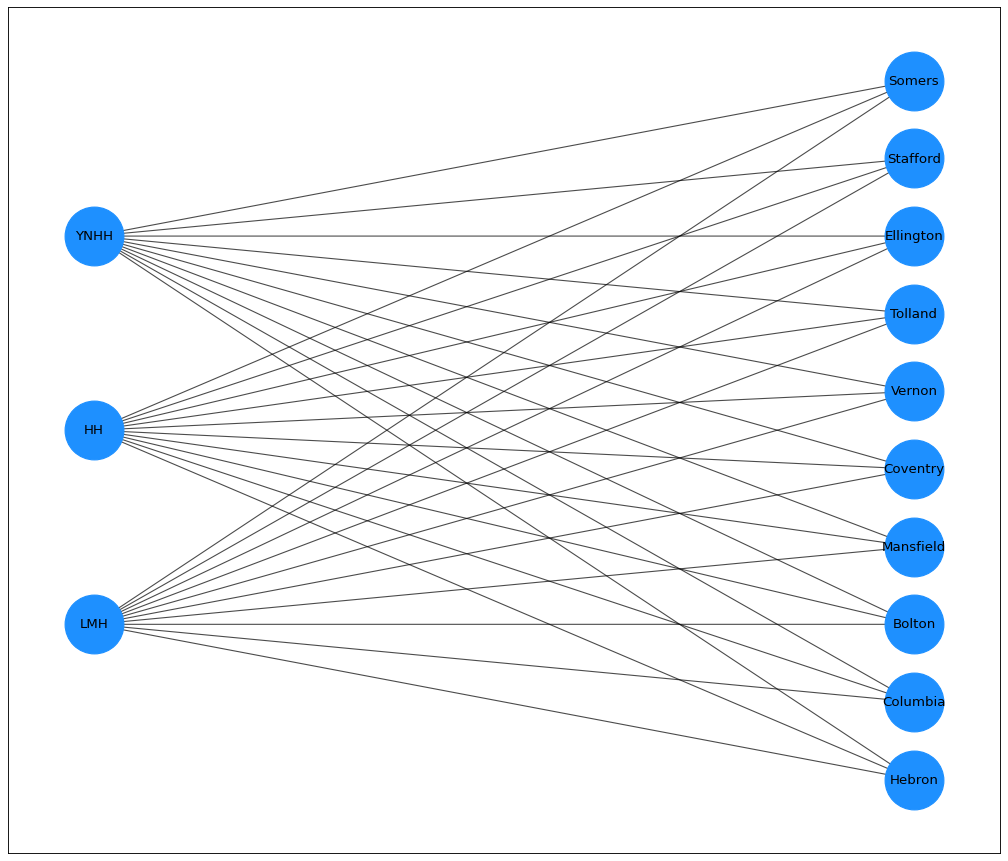

In [ ]:
import networkx as nx # We are importing networkx package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks
import matplotlib.pyplot as plt # We are importing Pylot, Matplotlib module that will allow us to create plots
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')

G = nx.DiGraph()
G.add_edges_from(
    [('YNHH', 'A'), ('YNHH', 'B'), ('YNHH', 'C'), ('YNHH', 'D'), ('YNHH', 'E'), ('YNHH', 'F'), ('YNHH', 'G'), ('YNHH', 'H'), ('YNHH', 'I'), ('YNHH', 'J'),
    ('HH', 'A'), ('HH', 'B'), ('HH', 'C'), ('HH', 'D'), ('HH', 'E'), ('HH', 'F'), ('HH', 'G'), ('HH', 'H'), ('HH', 'I'), ('HH', 'J'), 
     ('LMH', 'A'), ('LMH', 'B'), ('LMH', 'C'), ('LMH', 'D'), ('LMH', 'E'), ('LMH', 'F'), ('LMH', 'G'), ('LMH', 'H'), ('LMH', 'I'), ('LMH', 'J')])

# We are adding the labels for our nodes:
labels = {'A':'Somers', 'B':'Stafford', 'C':'Ellington', 'D':'Tolland', 'E':'Vernon', 'F':'Coventry', 'G':'Mansfield', 'H':'Bolton', 'I':'Columbia', 'J':'Hebron','YNHH':'YNHH','HH':'HH','LMH':'LMH'}

# We are specifying the positions of the nodes:
fixed_positions = {'YNHH':(1, 28),'HH':(1, 18),'LMH':(1, 8) ,'A':(36, 36),'B':(36, 32),'C':(36, 28),'D':(36, 24), 'E':(36, 20), 'F':(36, 16), 'G':(36, 12), 'H':(36, 8), 'I':(36, 4), 'J':(36, 0)} 
fixed_nodes = fixed_positions.keys() 

# We are specifying the layout details, such as node size, node color, arrow size, etc.:
pos = nx.spring_layout(G, k=2, pos=fixed_positions  ,fixed=fixed_nodes, iterations=100, threshold=0.0001, weight='weight', scale=1, center= [0,100], dim=2)
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw_networkx_nodes(G, pos=fixed_positions,  node_size = 2800, node_color= '#1E90FF', )
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize= 20, alpha=0.7, min_target_margin=5)

plt.show()

## **7. Minimal Cost Flow Model**

### Nodes
* **Supply nodes:** These are our 3 hospitals - Yale New Haven Hospital, Hartford Hospital and Lawrence and Memorial Hospital. These nodes **add** flow to the network, and the value of $B$ is positive for them.
* **Demand nodes:** These are 10 towns we selected from the Tolland county. These nodes **remove** flow from the network, and the value of $B$ is negative for them.


### Arcs
The arcs of a network represent the connections between nodes. The arcs in our network problems have three parameters of interest:
* **Cost per unit:** The amount we will have to pay for each unit being transported through that arc. It is the **flow cost** and the goal is to minimize this cost. In our case the shipping price to transport the vaccine is directly proportional to distance, and we have to pay $1 per each 1km of distance between our supply nodes and demand nodes.
* **Lower bound:** It is the minimum flow that has to pass through the arc.
* **Upper bound:** It is the maximum volume of flow that has to pass through the arc. 

In [ ]:
# we are import pyomo cbc to sovle the problem
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
# We are installing cbc:
!apt-get install -y -qq coinor-cbc

     |████████████████████████████████| 9.4MB 4.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 256kB 52.7MB/s 
     |████████████████████████████████| 163kB 46.5MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 144898 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coi

Demand (Towns) nodes - with negative values (no of cases) and Supply (Hospitals) nodes - with positive values (no of available vaccines). Merge both the nodes into single node dictionary.

In [ ]:
# Hospital nodes and vaccines availability - Supply nodes have B with positive values:
Hosplist = {key: value for (key, value) in dfhospital['Vaccines'].iteritems()}

# Town nodes and number of cases - Demand nodes have B with negative values:
Townlist = {key: -value for (key, value) in selectedtowns['Cases'].iteritems()}

# We are merging the dictionaries - Final B node
B = {**Hosplist, **Townlist}

Setting the Lower bound to 0 and upper bound to maximum no of cases (for demand nodes).


In [ ]:
# We are initializing cost, lower and upper bound dictionaries:
Cost = {}
LB = {}
UB = {}

# Here we are creating arcs: permutation of hospital and town nodes
# For each hospital node:
for h in dfhospital.index:
  # For each town node:
  for t in selectedtowns.index:
    key = h + '_' + t
    # Populating cost from pairwise matrix:
    Cost[key] = pairwise_dist_matrix.loc[pairwise_dist_matrix.index == h][t].values[0]
    # Setting lower bound 
    LB[key] = 0 #make it all 0 s
    # Setting the upper bound to current cases:
    UB[key] = selectedtowns.loc[selectedtowns.index == t]['Cases'].values[0]

# We are creating a list of nodes in the network:
nodes = list(B.keys())

# We are creating a list of arcs in the network:
arcs = list(LB.keys())

Create a Model with following constraints:

**Constraint 1**: Number of vaccines required should not exceed the available vaccines

**Constraint 2**: Each hospital should provide should provide at least 30% of total vaccines required by the county

**Constraint 3**: We must meet all the vaccine demand by the county

In [ ]:
def create_bounds(model, i):
   return (LB[i], UB[i])

# We are declaring the concrete model:
model = ConcreteModel()

# We are creating the variables:
model.x = Var(arcs, domain = NonNegativeReals, bounds=create_bounds)

# We are specyfying the constraints:
model.constraints = ConstraintList()
for node in nodes:
  flow_expr = 0
  for arc in arcs:
    u,v = arc.split('_')
    # Arc is pushing flow in the node:
    if node == u:
      flow_expr += model.x[arc]

    # Arc is pulling flow from the node:
    if node == v:
      flow_expr -= model.x[arc]

  # Flow balance defined by B
  # Supply node, production bounded by B
  if 0 < B[node]:
    model.constraints.add(flow_expr <= B[node])
    model.constraints.add(flow_expr>=round(0.3*sum(selectedtowns['Cases']),0))
  # Transshipment node, net flow must be zero
  elif 0 == B[node]:
    model.constraints.add(flow_expr == B[node])
  # We must meet all demand, so flow must equals B
  else:
    model.constraints.add(flow_expr == B[node])

# We are specifying our objective function:
obj_expr = 0.0
for arc in arcs:
  obj_expr += Cost[arc]*model.x[arc]

model.cost = Objective(
    expr = obj_expr, 
    sense = minimize)

# model.pprint()

# We are solving the model:
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model).write()

# We are showing the results:
print('Total cost:',model.cost())
# print('Arc flow:')
# for arc in arcs:
#   print("\tFlow at arc",arc,":",model.x[arc]())
# print('Node flow:')
# for node in nodes:
#   flow = 0
#   for arc in arcs:
#     u,v = arc.split('_')
#     # Arc is pushing flow in the node
#     if node == u:
#       flow += model.x[arc]()
      
#     # Arc is pulling flow from the node
#     if node == v:
#       flow -= model.x[arc]()
#   print("\tFlow at node",node,":",flow)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 77732.77841
  Upper bound: 77732.77841
  Number of objectives: 1
  Number of constraints: 17
  Number of variables: 31
  Number of nonzeros: 30
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number

**The Model gives the optimal solution. Lets print the nodes and arcs output in a table.** 

In [ ]:
# This code displays the distribution of vaccines in each town:
d = {}

columns = []
for node in nodes:  
  row = []
  for arc in arcs:
    u,v = arc.split('_')
    # Arc is pushing flow in the node
    if node == u:
      row.append(model.x[arc]()) 
    if node == v:
      columns.append(v)
  if(len(row) != 0):
    d[node] = row

table = pd.DataFrame.from_dict(d, orient= "index", columns= selectedtowns['TOWN'])
table.loc['Total'] = table.sum()
table['Total'] = table.sum(axis= 1)
table

TOWN   Somers  Stafford  Ellington  Tolland  ...  Bolton  Columbia  Hebron   Total
YNHH      0.0       0.0        0.0     82.0  ...    39.0       0.0    32.0   472.0
HH      323.0     130.0      133.0      0.0  ...     0.0       0.0     0.0   629.0
LMH       0.0       0.0        0.0      0.0  ...     0.0      32.0    23.0   472.0
Total   323.0     130.0      133.0     82.0  ...    39.0      32.0    55.0  1573.0

[4 rows x 11 columns]

**Minimal Cost Flow Model Cost**

- The total cost of distributing the Covid-19 vaccines to our selected Tolland county towns utilizing the Minimal Cost Flow Model is `$`77,732.78.
- We know that Hartford hospital is the closest to Tolland county. From the model's results we can tell that Tolland, Vernon and Bolton are located closer to Yale New Haven hospital than other towns, and Coventry, Mansfield, Columbia and Hebron are located closer to Lawrence and Memorial hospital than other Tolland county's towns.

## **8. Monte Carlo Simulation**

In the next step, we are assuming that the cases at each town centroid follow a triangle distribution. We are going to examine how much our model results change.

### **8.1 Single Iteration**

We are trying out the single iteration first. Every time you run the code below, the random cases will generate from the triangular distributions, and model results will change.

The demand distribution for the selected Tolland towns use the triangular random distributions:
* The min will be Covid-19 today 
* The max will be 5x current numbers
* The mode will be 2x current numbers

In [ ]:
# Single iteration
import time #this will allow us to time the iteration
start_time = time.time()
# Generating the random case value for each town:
B_temp = {key: -round(np.random.triangular(left= value, mode= value * 2, right= value * 5)) for (key, value) in selectedtowns['Cases'].iteritems()}
values = B_temp.values()
total_cases = negative(sum(list(values)[0:len(B_temp)])) # Get the total cases number for random numbers generated

# We are merging the town and hospital nodes:
B = {**Hosplist, **B_temp} # Hospital vaccines availability is the same

# Cost = {} - cost will not change - pairwise distance will remain the same

# Lower and upper bound of demand nodes will be according to randon value generated:
LB = {}
UB = {}
for h in dfhospital.index:
  for t in selectedtowns.index:
    key = h + '_' + t
    # Cost[key] = pairwise_dist_matrix.loc[pairwise_dist_matrix.index == h][t].values[0]
    LB[key] = 0 
    UB[key] = -B[t]

# We are creating a list of nodes in the network:
nodes = list(B.keys())

# We are creating a list of arcs in the network:
arcs = list(LB.keys())

# We are declaring the concrete model:
model = ConcreteModel()

# We are creating variables:
model.x = Var(arcs, domain = NonNegativeReals, bounds=create_bounds)

# We are specifying the constraints:
model.constraints = ConstraintList()
for node in nodes:
  flow_expr = 0
  for arc in arcs:
    u,v = arc.split('_')
    # Arc is pushing flow in the node
    if node == u:
      flow_expr += model.x[arc]

    # Arc is pulling flow from the node
    if node == v:
      flow_expr -= model.x[arc]

  # Flow balance defined by B
  # Supply node, production bounded by B
  if 0 < B[node]:
    model.constraints.add(flow_expr <= B[node])
    model.constraints.add(flow_expr>= round(0.3*total_cases,0))
  # Transshipment node, net flow must be zero
  elif 0 == B[node]:
    model.constraints.add(flow_expr == B[node])
  # We must meet all demand, so flow must equals B
  else:
    model.constraints.add(flow_expr == B[node])

# We are specifying the objective function:
obj_expr = 0.0
for arc in arcs:
  obj_expr += Cost[arc]*model.x[arc]

model.cost = Objective(
    expr = obj_expr, 
    sense = minimize)

SolverFactory('cbc', executable='/usr/bin/cbc').solve(model)

# We are showing the results:
print('Total cost:',model.cost())

# We are showing the vaccine distribution in a table:
d = {}

columns = []
for node in nodes:  
  row = []
  for arc in arcs:
    u,v = arc.split('_')
    # Arc is pushing flow in the node
    if node == u:
      row.append(model.x[arc]()) 
    if node == v:
      columns.append(v)
  if(len(row) != 0):
    d[node] = row
#Calculate time for 1 iteration
print("It took %s seconds to run this model" % (time.time() - start_time))

table = pd.DataFrame.from_dict(d, orient= "index", columns= selectedtowns['TOWN'])
table.loc['Total'] = table.sum()
table['Total'] = table.sum(axis= 1)
table


Total cost: 197762.63862634677
It took 0.035500526428222656 seconds to run this model


TOWN   Somers  Stafford  Ellington  Tolland  ...  Bolton  Columbia  Hebron   Total
YNHH      0.0       0.0        0.0    143.0  ...   119.0       0.0     0.0  1192.0
HH      700.0     352.0      328.0      0.0  ...     0.0       0.0     0.0  1589.0
LMH       0.0     127.0        0.0      0.0  ...     0.0      80.0   125.0  1192.0
Total   700.0     479.0      328.0    143.0  ...   119.0      80.0   125.0  3973.0

[4 rows x 11 columns]

### **8.2 Monte Carlo Minimum Cost Flow Model - For 10,000 Iterations** 

Now we are ready to do the iteration for 10,000 times and see the plots for our model!

In [ ]:
# Now lets run it for 10,000 times!
# Added the 7.1 code inside for loop, disables all the print statements to fasten the execution.
# We create 2 lists to store cities' distribution and total cost results:
start_timemc = time.time()
results = [] # This is the list for total cost
Bs = [] # This is list for all cities random distributions
valuesmcs = []
for a in np.arange(0,10000,1):

  # Random demand for each town, converting the values to negative
  B_tempmc = {key: -round(np.random.triangular(left= value, mode= value * 2, right= value * 5)) for (key, value) in selectedtowns['Cases'].iteritems()}
  Bs.append(B_tempmc)
  valuesmc = B_tempmc.values()
  valuesmcs.append(list(valuesmc))
  total_cases_mc = negative(sum(list(valuesmc)[0:len(B_tempmc)]))
  # Merge Hospital supply and towns demand in one list.
  B = {**Hosplist, **B_tempmc}

  # Cost = {} - cost will not change
  # Upper and lower bounds
  LB = {}
  UB = {}
  for h in dfhospital.index:
    for t in selectedtowns.index:
      key = h + '_' + t
      LB[key] = 0 
      UB[key] = -B[t]

  # We are creating a list of nodes in the network:
  nodes = list(B.keys())

  # We are creating a list of arcs in the network:
  arcs = list(LB.keys())

  # We are declaring the concete model:
  model = ConcreteModel()

  # We are creating variables:
  model.x = Var(arcs, domain = NonNegativeReals, bounds=create_bounds)

  # We are specifying the constraints:
  model.constraints = ConstraintList()
  for node in nodes:
    flow_expr = 0
    for arc in arcs:
      u,v = arc.split('_')
      # Arc is pushing flow in the node
      if node == u:
        flow_expr += model.x[arc]

      # Arc is pulling flow from the node
      if node == v:
        flow_expr -= model.x[arc]

    # Flow balance defined by B
    # Supply node, production bounded by B
    if 0 < B[node]:
      model.constraints.add(flow_expr <= B[node])
      model.constraints.add(flow_expr>=round(0.3*total_cases_mc,0))
    # Transshipment node, net flow must be zero
    elif 0 == B[node]:
      model.constraints.add(flow_expr == B[node])
    # We must meet all demand, so flow must equals B
    else:
      model.constraints.add(flow_expr == B[node])

  # We are specifying the objective function:
  obj_expr = 0.0
  for arc in arcs:
    obj_expr += Cost[arc]*model.x[arc]

  model.cost = Objective(
      expr = obj_expr, 
      sense = minimize)

  SolverFactory('cbc', executable='/usr/bin/cbc').solve(model)

  results = np.append(results, model.cost())
# Lets see how long it take to run this Monte Carlo Min Cost Model!
print("It took %s minutes to run this model" % round((time.time() - start_timemc)/60,4))


# Print the shape
print(results.shape) # 10K entries just like we asked
# What's the mean of the distribution?
print(np.mean(results))
# Min and max?
print(np.min(results)) 
print(np.max(results)) 



It took 5.5958 minutes to run this model
(10000,)
207848.232026621
122997.53182300039
307148.8842612643


The distribution of total cost is a normal distribution with a mean of `$`207,611.14, minimum of `$`127,760.65, and maximum of `$`315,503.47. The cost rises since we assume that the number of cases will possibly double in the future.

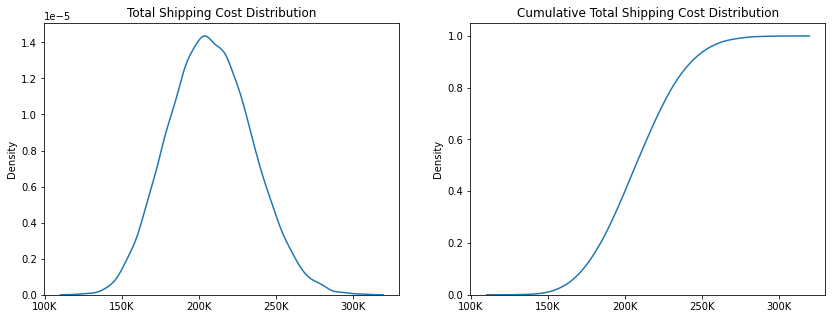

In [ ]:
# We are plotting out the total cost distribution for 10000 iterations:
fig, axes = plt.subplots(1,2, figsize = (14,5))

# Plot PDF
sns.kdeplot(data=results, ax = axes[0]).set_title('Total Shipping Cost Distribution')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0].get_xticks()/1000]
axes[0].set_xticklabels(xlabels)

# Plot CDF
sns.kdeplot(data=results, ax = axes[1], cumulative= True).set_title('Cumulative Total Shipping Cost Distribution')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in axes[1].get_xticks()/1000]
axes[1].set_xticklabels(xlabels)
plt.show()

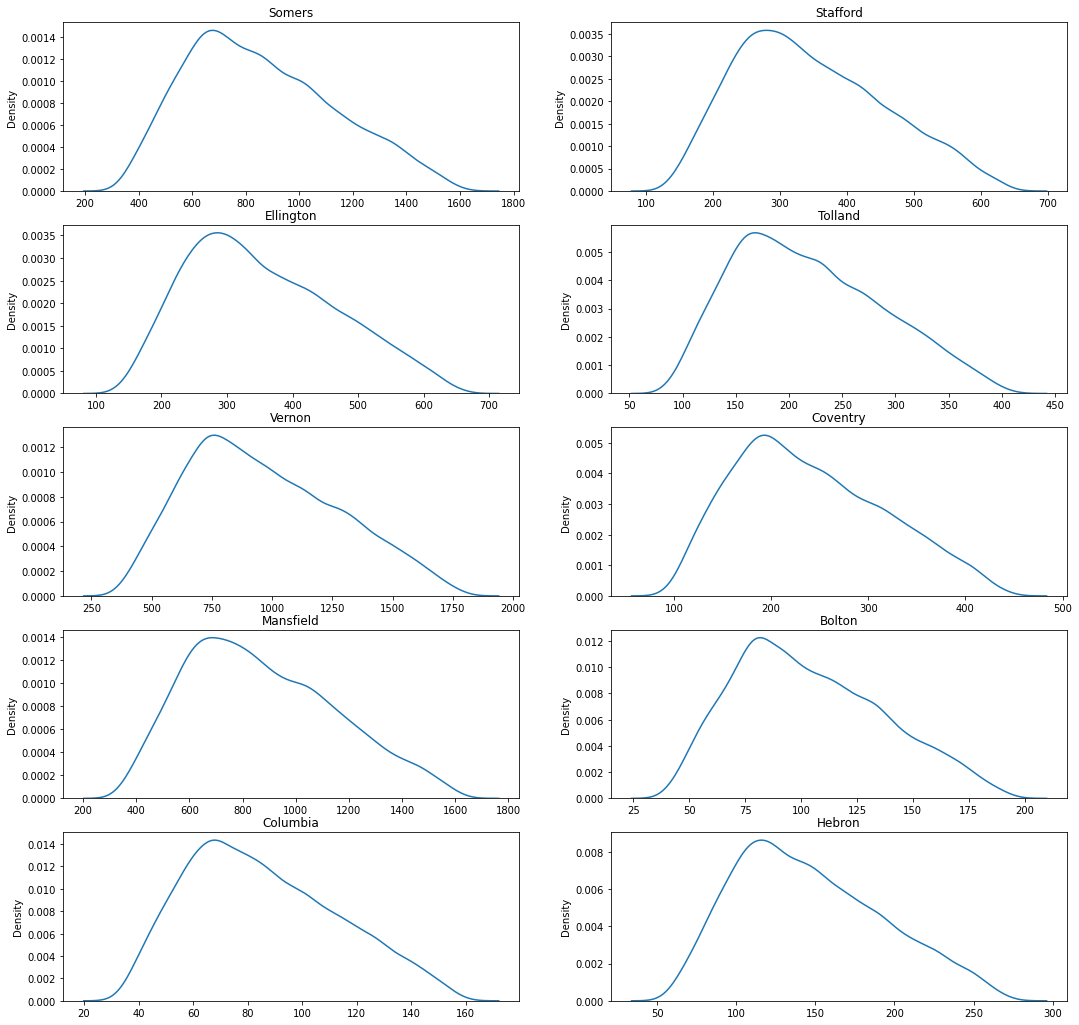

In [ ]:
# We are printing out the 10 demand distributions of the selected Tolland county towns:
fig, axes = plt.subplots(5, 2, figsize=(18, 18))
temps = {}
for key in B_temp.keys():
  temp = []
  for i in range(len(Bs)):
    temp.append(abs(Bs[i][key]))
  temps[key] = temp

position = 0
keys = list(temps.keys())
tname  = selectedtowns['TOWN']
for i in range(5):
  for j in range(2):
    sns.kdeplot(data=temps[keys[position]],ax = axes[i,j]).set_title(tname[position])
    position += 1
plt.show()
# All are triangular distribution as expected!

In [ ]:
# Now let's plot the distribution in a different way!
import plotly.figure_factory as ff
import numpy as np

group_labels = list(B_temp.keys())
data= negative(valuesmcs)
data = list(map(list, zip(*data)))
# Create distplot with custom bin_size
fig = ff.create_distplot(data, group_labels, bin_size=.2)
fig.update_layout(title_text='Distribution Plot of 10 Towns')
fig.show()

### **8.3 Monte Carlo Min Cost Model 2 - Decrease supply constraint**

Now we are using the exact same code from 8.2, except this time we are decreasing the percent of total vaccinces we shipped from each hospital from 30% to 10% (to see if we can possibly decrease the cost).

In [ ]:
# Now lets run it for 10000 times!
# Added the 7.1 code inside for loop, disables all the print statements to fasten the execution.
start_timemc2 = time.time()
# We create 2 lists to store cities' distribution and total cost results:
results2 = [] # This is the list for total cost
Bs2 = [] # This is list for all cities random distributions
valuesmcs2 = []
for a in np.arange(0,10000,1):

  B_tempmc2 = {key: -round(np.random.triangular(left= value, mode= value * 2, right= value * 5)) for (key, value) in selectedtowns['Cases'].iteritems()}
  Bs2.append(B_tempmc2)
  valuesmc2 = B_tempmc2.values()
  valuesmcs2.append(list(valuesmc2))
  total_cases_mc2 = negative(sum(list(valuesmc2)[0:len(B_tempmc2)]))

  # Merge Hospital supply and towns demand in one list.
  B = {**Hosplist, **B_tempmc2}
  # Cost = {} - cost will not change
  LB = {}
  UB = {}
  for h in dfhospital.index:
    for t in selectedtowns.index:
      key = h + '_' + t
      LB[key] = 0 
      UB[key] = -B[t]

  # We are creating a list of nodes in the network:
  nodes = list(B.keys())

  # We are creating a list of arcs in the network:
  arcs = list(LB.keys())

  # We are declring the concrete model:
  model = ConcreteModel()

  # We are creating variables:
  model.x = Var(arcs, domain = NonNegativeReals, bounds=create_bounds)

  # We are specifying the constraints:
  model.constraints = ConstraintList()
  for node in nodes:
    flow_expr = 0
    for arc in arcs:
      u,v = arc.split('_')
      # Arc is pushing flow in the node
      if node == u:
        flow_expr += model.x[arc]

      # Arc is pulling flow from the node
      if node == v:
        flow_expr -= model.x[arc]


    # Flow balance defined by B
    # Supply node, production bounded by B
    if 0 < B[node]:
      model.constraints.add(flow_expr <= B[node])
      model.constraints.add(flow_expr>=round(0.1*total_cases_mc2,0)) #Now the supply constraints drop to 0.1
    # Transshipment node, net flow must be zero
    elif 0 == B[node]:
      model.constraints.add(flow_expr == B[node])
    # We must meet all demand, so flow must equals B
    else:
      model.constraints.add(flow_expr == B[node])

  # We are specifying the objective function:
  obj_expr = 0.0
  for arc in arcs:
    obj_expr += Cost[arc]*model.x[arc]

  model.cost = Objective(
      expr = obj_expr, 
      sense = minimize)

  SolverFactory('cbc', executable='/usr/bin/cbc').solve(model)

  results2.append(model.cost())

# Lets see how long it take to run this Monte Carlo Min Cost Model!
# Lets see how long it take to run this Monte Carlo Min Cost Model!
print("It took %s minutes to run this model" % round((time.time() - start_timemc2)/60,4))

# We are printing the shape:
print(len(results2)) # 10K entries just like we asked
# What's the mean of the distribution?
print(np.mean(results2))
# Min and max?
print(np.min(results2)) 
print(np.max(results2)) 


It took 5.8354 minutes to run this model
10000
146921.28678512588
89178.99716611816
221111.06564358453


The distribution of the total cost is a normal distribution with a mean of `$`146,893.64, minimum of `$`92,599.72, and maximum of `$`221,737.33. The cost dropped compared with the first Monte Carlo model since we lowered the supply constraint from 30% to 10%. It will be more cost-efficient to ship most vaccines from the closest hospital, which is Hartford Hospital.

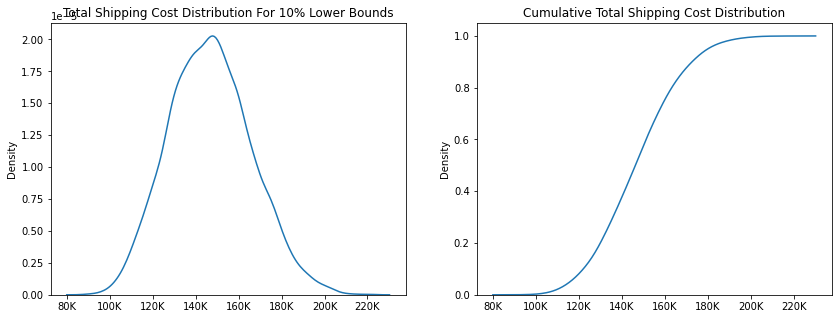

In [ ]:
# We are plotting out the total cost distribution for 10000 iterations:
fig, axes = plt.subplots(1,2, figsize = (14,5))

# Plot PDF
sns.kdeplot(data=results2, ax = axes[0]).set_title('Total Shipping Cost Distribution For 10% Lower Bounds')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0].get_xticks()/1000]
axes[0].set_xticklabels(xlabels)

# Plot CDF
sns.kdeplot(data=results2, ax = axes[1], cumulative= True).set_title('Cumulative Total Shipping Cost Distribution')
xlabels = ['{:,.0f}'.format(x) + 'K' for x in axes[1].get_xticks()/1000]
axes[1].set_xticklabels(xlabels)
plt.show()

Looking at the plot and the mean of the new distribution of total cost, we can see that the cost did drop! (From `$`230,000 to `$`160,000)

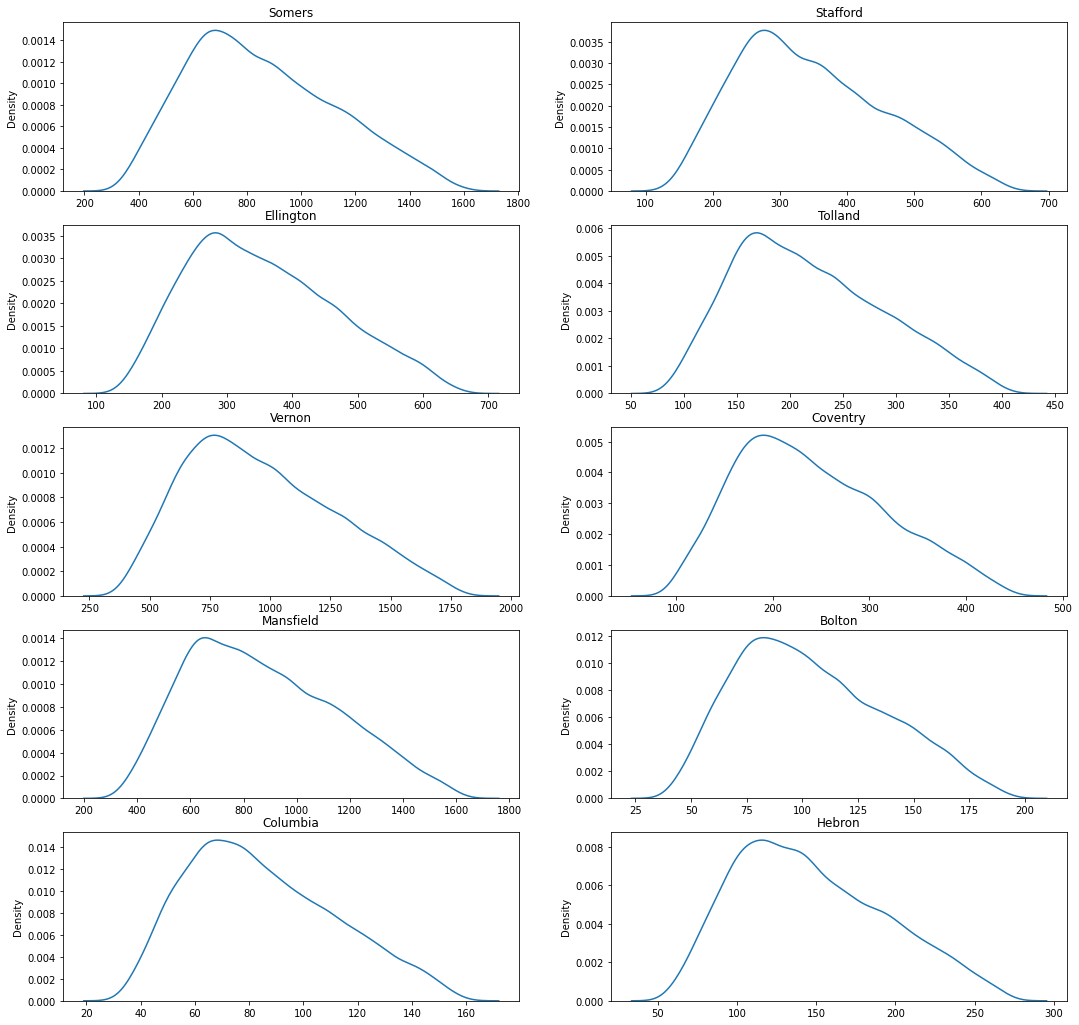

In [ ]:
# We are printing out the 10 demand distributions of the cities selected:
fig, axes = plt.subplots(5, 2, figsize=(18, 18))
temps = {}
for key in B_temp.keys():
  temp = []
  for i in range(len(Bs2)):
    temp.append(abs(Bs2[i][key]))
  temps[key] = temp

position = 0
keys = list(temps.keys())
tname  = selectedtowns['TOWN']
for i in range(5):
  for j in range(2):
    sns.kdeplot(data=temps[keys[position]],ax = axes[i,j]).set_title(tname[position])
    position += 1
plt.show()
# All are triangular distribution as expected!

In [ ]:
# Now let's plot the distribution in a different way!
import plotly.figure_factory as ff
import numpy as np

group_labels = list(B_temp.keys())
data= negative(valuesmcs2)
data = list(map(list, zip(*data)))
# Create distplot with custom bin_size
fig = ff.create_distplot(data, group_labels, bin_size=.2)
fig.update_layout(title_text='Distribution Plot of 10 Towns')
fig.show()

## **9. Conclusions**

- Using just the Minimal Cost Flow Model with the constraint that at least 30% of total vaccines need to come from three assigned hospitals, our model cost is $77,732.78.

- Monte Carlo Simulation Model simulate Covid-19 cases will follow the triangular distribution. We can see that the government needs to allocate about `$`210k under our first model (30%) to prepare for the possibility that case will double; and about `$`150k, under the second model (10%) to meet the demands. 

- Since Covid-19 cases increase rapidly, it is better for the government to allocate the shipping cost at maximum estimated costs, which are `$`316K under the first model and `$`222K under the second model.

- We recommend that stakeholders and decision makers follow the second model since the model only requires that at least 10% supply comes from each hospital. In this way, the government can save the shipping cost (and time as well) for about `$`60K on an average level.

- It is not surprising that once we reduced the percent of total vaccinces shipped from each hospital from 30% to 10%, we reduced the cost as the closest hospital (Hartford Hospital) became our primary supplier of the Covid-19 vaccine in Tolland county. Shipping cost is based on the distance from hospital to town, and Hartford Hospital is the best fit for our model as it is located in close proximity to Tolland county.

- Cost overruns are very problematic and create a lot of budgeting problems. Utilizing Monte Carlo simulation can assist in mitigating risk of project going over the budget.

- We learned that Monte Carlo simulation needs a good assumption input in order to get a more accurate output. For example, we did not expect Covid-19 cases to increase far more than the maximum number (5x) we discussed here, which may led to an underestimated output in real life. 